In [2]:
import nibabel as nib
from nilearn.connectome import ConnectivityMeasure
import numpy as np
from nilearn import plotting

import pandas as pd
import numpy as np

import os
import matplotlib.pyplot as plt

from scipy.signal import butter, filtfilt, iirfilter, freqs
from scipy.signal import freqz
from scipy import stats
from scipy.stats import pearsonr
from scipy import signal
import os

In [11]:
def savefiles(mtx, title, filename, typ):
    
    if (typ == "png") or (typ == "pngcsv"):
        # save img
        plt.matshow(mtx)
        plt.title(title)
        plt.colorbar()
        plt.savefig(filename+".png")
        plt.close()

    if (typ == "csv") or (typ == "pngcsv"):
        # save csv
        np.savetxt(filename+".csv", mtx , delimiter=",")

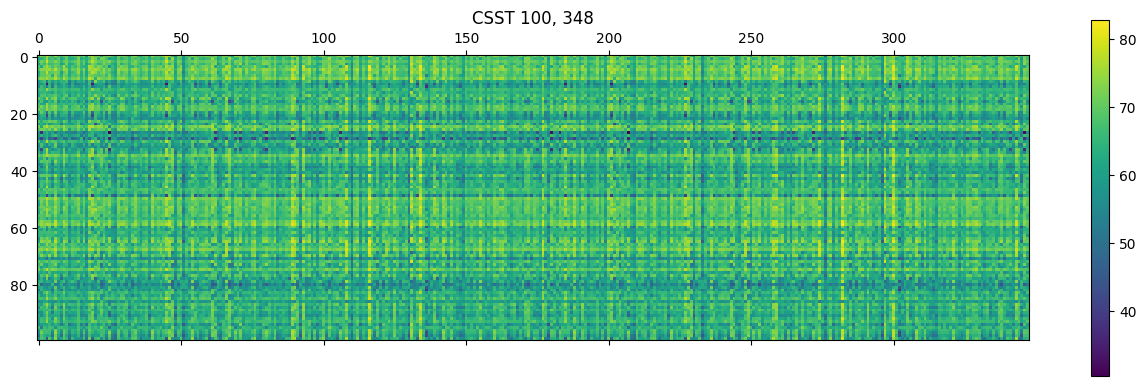

In [24]:
""" SECOND LEVEL ANALYSIS """

# Get the list of all files and directories
in_path_CN = "./outputs/connect_state/CN/"
in_path_AD = "./outputs/connect_state/AD/"
dir_list_CN = os.listdir(in_path_CN)
dir_list_AD = os.listdir(in_path_AD)

N_voxels = 100
N_states = len(dir_list_CN) + len(dir_list_AD)
CSST = np.zeros([N_voxels, N_states]) # 100, 182+166=348

# connectivity states
E = dict()

for state, value in enumerate(dir_list_CN + dir_list_AD):

    try:
        E[state] = pd.read_csv(in_path_CN+value, header=None) # 100, 100
    except:
        E[state] = pd.read_csv(in_path_AD+value, header=None) # 100, 100
        
    # connectivity strength of each state
    CSST[:,state] = E[state].sum(axis=1) # 100, 348
    

# visualise
plt.matshow(CSST)
plt.title("CSST "+str(N_voxels)+", "+str(N_states))
plt.colorbar()
plt.show()
savefiles(CSST, "CSST", "./outputs/connect_state/CSST", "pngcsv")

# new similarity matrix
CSST = pd.DataFrame(CSST)
Ccsst = CSST.corr(method ='pearson')
savefiles(Ccsst, "Ccsst", "./outputs/connect_state/Ccsst", "pngcsv")

# go to matlab

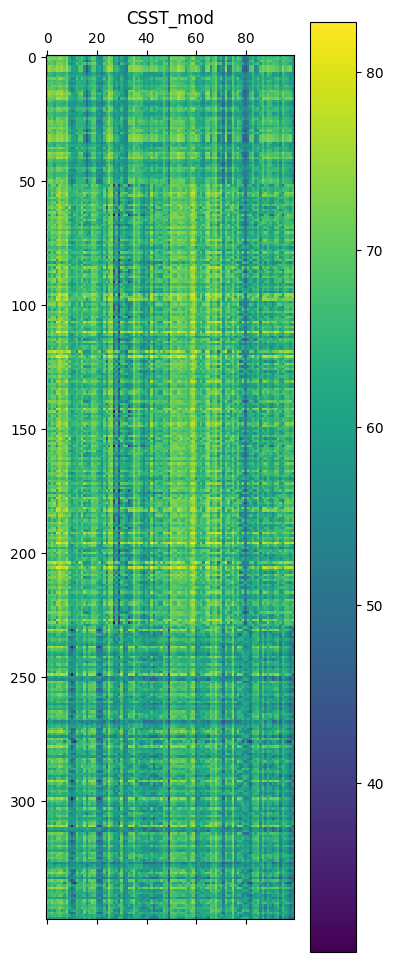

In [25]:
Ci = np.array(pd.read_csv("./outputs/modularity/Ci_csst.csv", header=None))

max_Ci = int(max(Ci))
CSST_mod = []
CSST = np.array(CSST)
mod_inds = dict()
for m in (range(1,max_Ci+1)): # m = 3
    ind = [index for index, value in enumerate(Ci) if value == m]
    mod_inds[m] = ind
    for i in ind:
        # order
        CSST_mod.append(CSST[:,i])

CSST_mod = np.array(CSST_mod)
plt.matshow(CSST_mod)
plt.title("CSST_mod")
plt.colorbar()
plt.show()

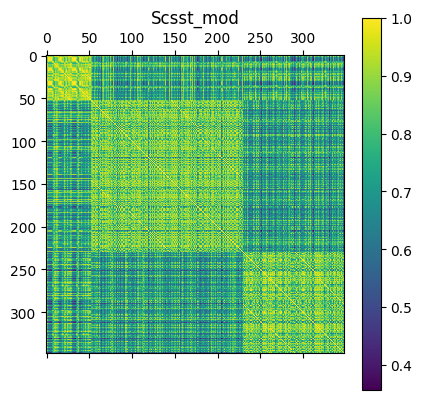

In [26]:
CSST_mod = pd.DataFrame(CSST_mod.T)
csst_mod = CSST_mod.corr(method ='pearson')
Scsst_mod = (csst_mod + 1)/ 2

plt.matshow(Scsst_mod)
plt.title("Scsst_mod")
plt.colorbar()
plt.show()

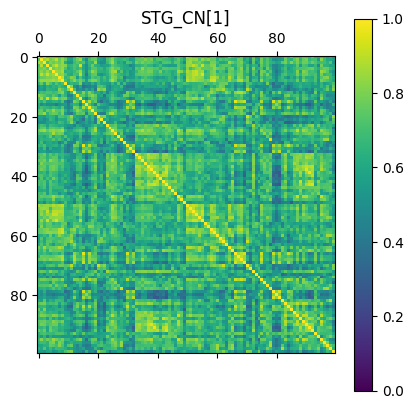

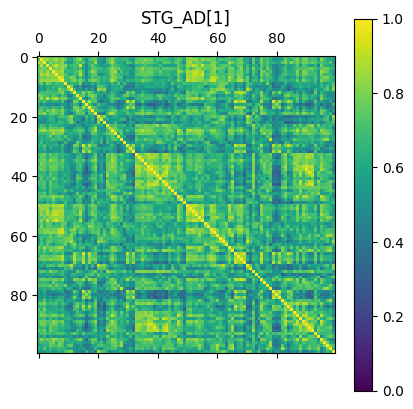

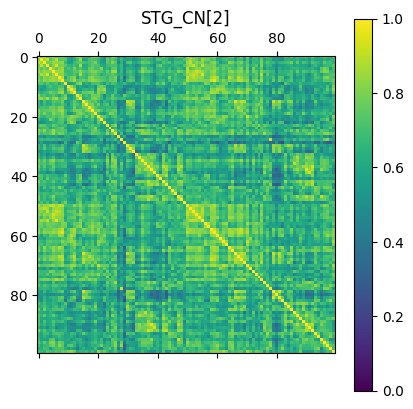

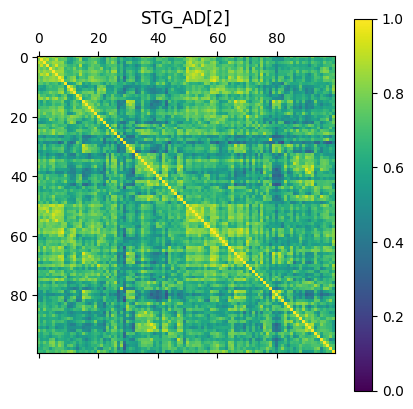

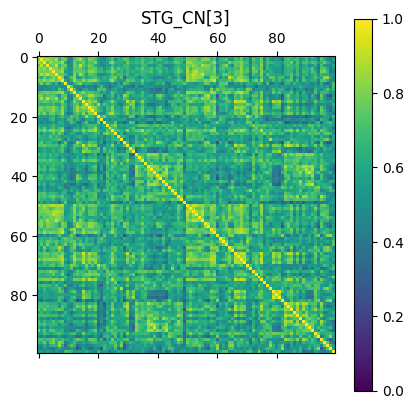

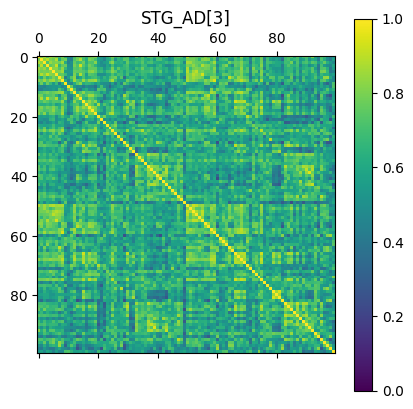

In [27]:
STG_CN = dict()
STG_AD = dict()
for mod_no in (range(1,max_Ci+1)):
    states_sum_CN = np.zeros([100, 100])
    states_sum_AD = np.zeros([100, 100])
    count_mod_CN = 0
    count_mod_AD = 0
    for ind in mod_inds[mod_no]:
        if ind < 182:
            states_sum_CN = states_sum_CN + E[ind]
            count_mod_CN = count_mod_CN + 1
        else:
            states_sum_AD = states_sum_AD + E[ind]
            count_mod_AD = count_mod_AD + 1
    STG_CN[mod_no] = states_sum_CN/count_mod_CN
    STG_AD[mod_no] = states_sum_AD/count_mod_AD
    
    plt.matshow(STG_CN[mod_no])
    plt.title("STG_CN["+str(mod_no)+"]")
    plt.clim(0,1)
    plt.colorbar()
    plt.show()
    
    plt.matshow(STG_AD[mod_no])
    plt.title("STG_AD["+str(mod_no)+"]")
    plt.clim(0,1)
    plt.colorbar()
    plt.show()

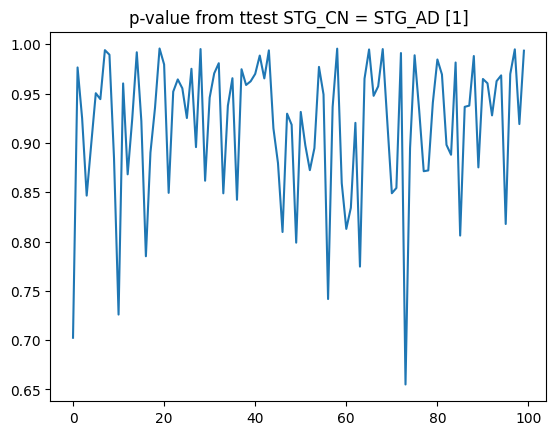

Empty DataFrame
Columns: []
Index: []


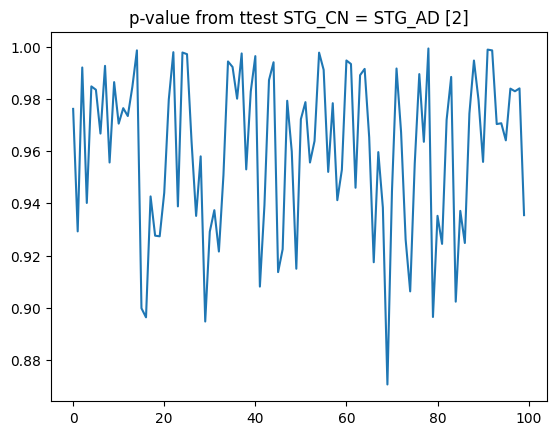

Empty DataFrame
Columns: []
Index: []


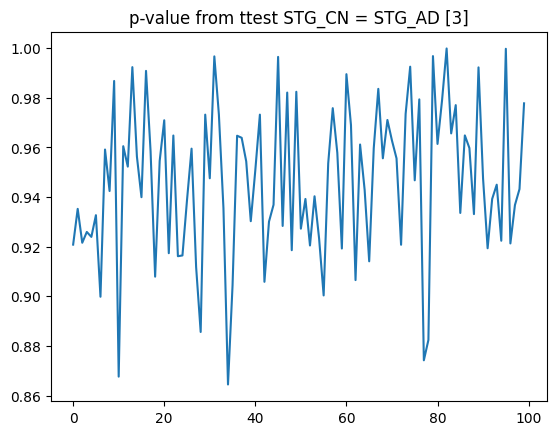

Empty DataFrame
Columns: []
Index: []


In [28]:
""" T-TEST -- STG_CN=STG_AD """
for mod_no in (range(1,max_Ci+1)):

    ttest = stats.ttest_ind(a=STG_CN[mod_no], b=STG_AD[mod_no], equal_var=True)

    plt.plot(ttest.pvalue)
    plt.title("p-value from ttest STG_CN = STG_AD ["+str(mod_no)+"]")
    plt.show()

    pval_accept = []
    pval_accept_ind = []
    for ind, pval in enumerate(ttest.pvalue):
        if pval < 0.05:
            pval_accept.append(pval)
            pval_accept_ind.append(ind)

    # print major areas of difference (p-value <0.05 so we can reject null hypothesis)     
    print(pd.DataFrame(pval_accept, pval_accept_ind))

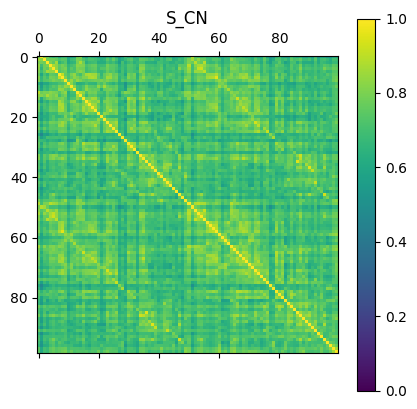

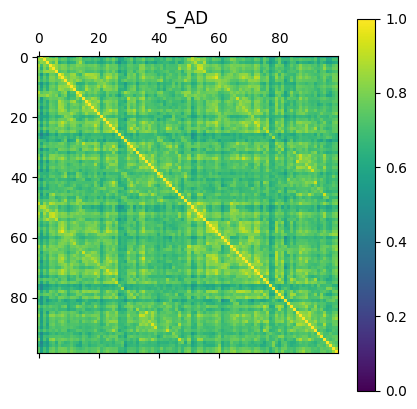

In [29]:
S_CN = pd.read_csv("./outputs/FC_CN.csv")
S_AD = pd.read_csv("./outputs/FC_AD.csv")

plt.matshow(S_CN)
plt.title("S_CN")
plt.clim(0,1)
plt.colorbar()
plt.show()


plt.matshow(S_AD)
plt.title("S_AD")
plt.clim(0,1)
plt.colorbar()
plt.show()

               0
4   2.205916e-02
10  2.607648e-05
11  3.008935e-04
12  5.463754e-03
16  3.602793e-02
20  6.355423e-04
21  9.166311e-03
22  7.318724e-03
26  4.386278e-02
29  1.157411e-02
33  5.695434e-07
37  3.522849e-02
38  5.638901e-04
46  2.500680e-07
48  1.738883e-04
50  3.908775e-02
53  3.654496e-02
63  1.629841e-04
73  4.201495e-03
76  1.146893e-02
81  3.105150e-02
82  1.107676e-02
88  4.091870e-07
89  4.419733e-04
90  5.861241e-04
91  9.000819e-04
95  4.725893e-03


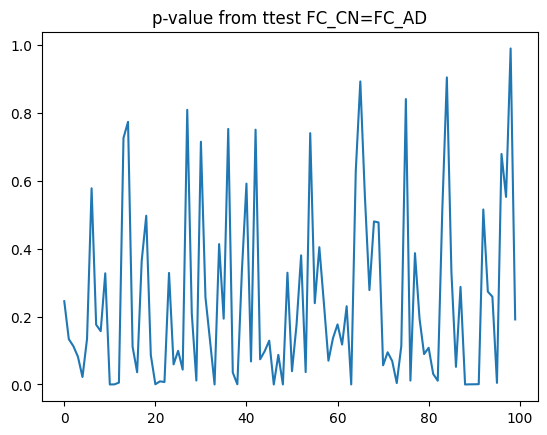

In [30]:
#T-TEST -- FC_CN=FC_AD

ttest = stats.ttest_ind(a=S_CN, b=S_AD, equal_var=True)

plt.plot(ttest.pvalue)
plt.title("p-value from ttest FC_CN=FC_AD")

pval_accept = []
pval_accept_ind = []
for ind, pval in enumerate(ttest.pvalue):
    if pval < 0.05:
        pval_accept.append(pval)
        pval_accept_ind.append(ind)

# print major areas of difference (p-value <0.05 so we can reject FC_CN=FC_AD)     
print(pd.DataFrame(pval_accept, pval_accept_ind))


In [132]:
"""add box plots - connectivity strength"""

data_strength_CN = []
data_strength_AD = []

for st in range(348):
    if st <182:
        # state strength over all voxels
        state_strength_CN = (E[st].sum(axis=1))/2/100
        data_strength_CN.append((state_strength_CN.sum())/100)
    else:
        # state strength over all voxels
        state_strength_AD = (E[st].sum(axis=1))/2/100
        data_strength_AD.append((state_strength_AD.sum())/100)

"""add box plots - clustering coef"""
# go to matlab

C_CN = pd.read_csv("./outputs/clustering/first_level_states_C_CN.csv")
C_AD = pd.read_csv("./outputs/clustering/first_level_states_C_AD.csv")

"""add box plots - global efficiency"""
Eff_CN = pd.read_csv("./outputs/efficiency/first_level_states_Eff_CN.csv")
Eff_AD = pd.read_csv("./outputs/efficiency/first_level_states_Eff_AD.csv")


(0.5, 0.75)

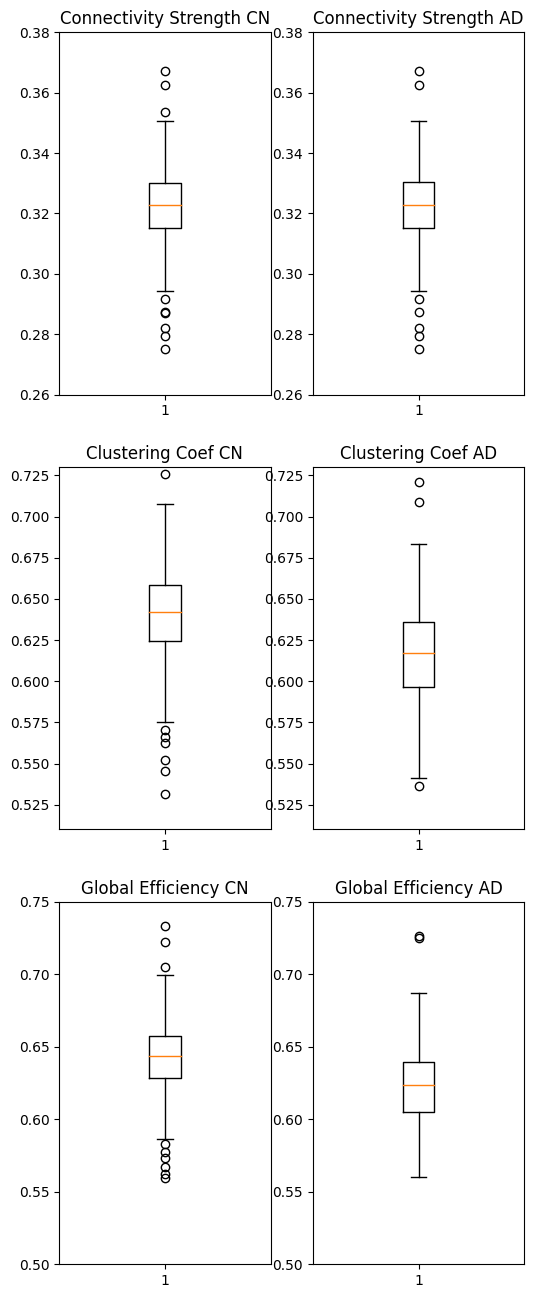

In [139]:
# visualizing

fig, axs = plt.subplots(3, 2, figsize=(6, 16))

# connection strength
axs[0,0].boxplot(data_strength_CN)
axs[0,0].set_title("Connectivity Strength CN")
axs[0,1].boxplot(data_strength_AD)
axs[0,1].set_title("Connectivity Strength AD")
axs[0,0].set_ylim(0.26, 0.38)
axs[0,1].set_ylim(0.26, 0.38)

# clustering coef
axs[1,0].boxplot(C_CN)
axs[1,0].set_title("Clustering Coef CN")
axs[1,1].boxplot(C_AD)
axs[1,1].set_title("Clustering Coef AD")
axs[1,0].set_ylim(0.51, 0.73)
axs[1,1].set_ylim(0.51, 0.73)

# global efficiency
axs[2,0].boxplot(Eff_CN)
axs[2,0].set_title("Global Efficiency CN")
axs[2,1].boxplot(Eff_AD)
axs[2,1].set_title("Global Efficiency AD")
axs[2,0].set_ylim(0.52, 0.75)
axs[2,1].set_ylim(0.52, 0.75)